# Discrete Densities at the Boundaries

In this section, we show how we obtained the figures in the paper that
motivate the need for our new definition of density at the boundary. We recall
that we defined
$$
\begin{align*}
q_1(t) &= \frac{2}{x_2(t) - x_1(t)} - \frac{2}{x_3(t) - x_1(t)}, \\
q_n(t) &= \frac{2}{x_n(t) - x_{n-1}(t)} - \frac{2}{x_n(t) - x_{n-2}(t)},
\end{align*}
$$
modifying the previous definitions $q_1(t) = 1/x_2(t)$ and $q_n(t) = 1/(x_n(t) - x_{n-1}(t))$.

To start, let us load in the packages we will need.

In [1]:
using StepwiseEQL
using CairoMakie
using EpithelialDynamics1D
using OrdinaryDiffEq
using LinearSolve

We now define and solve the `CellProblem`, and its
corresponding continuum limit.

In [2]:
force_law = (δ, p) -> p.k * (p.s - δ)
k, s, η, T = 50.0, 0.2, 1.0, 10.0
force_law_parameters = (k=k, s=s)
initial_condition = collect(LinRange(0, 5, 30))
prob = CellProblem(;
    force_law,
    force_law_parameters,
    final_time=T,
    damping_constant=η,
    initial_condition,
    fix_right=false)
sol = solve(prob, Tsit5(), saveat=0.02)
pde_prob = continuum_limit(prob, 5000, proliferation=false)
pde_sol = solve(pde_prob, TRBDF2(linsolve=KLUFactorization()), saveat=sol.t)

retcode: Success
Interpolation: 1st order linear
t: 501-element Vector{Float64}:
  0.0
  0.02
  0.04
  0.06
  0.08
  0.1
  0.12
  0.14
  0.16
  0.18
  ⋮
  9.84
  9.86
  9.88
  9.9
  9.92
  9.94
  9.96
  9.98
 10.0
u: 501-element Vector{Vector{Float64}}:
 [5.8, 5.8, 5.8, 5.8, 5.8, 5.8, 5.799999999999999, 5.800000000000001, 5.8, 5.800000000000001  …  5.799999999999996, 5.799999999999996, 5.799999999999996, 5.799999999999996, 5.799999999999996, 5.799999999999996, 5.799999999999996, 5.799999999999996, 5.799999999999996, 5.0]
 [5.799999999999999, 5.799999999999999, 5.800000000000001, 5.800000000000001, 5.799999999999999, 5.8, 5.8, 5.800000000000001, 5.799999999999999, 5.799999999999999  …  5.1924095336557405, 5.190495704337308, 5.188581949234203, 5.186668313326301, 5.184756020440565, 5.182847493803263, 5.1809447979123915, 5.17904652757611, 5.177146783848216, 5.020959142248633]
 [5.799999999999999, 5.8, 5.799999999999999, 5.799999999999999, 5.8, 5.8, 5.8, 5.800000000000001, 5.8, 5.7999999999

Next, we need to get the data for the densities at $t=2$,
as well as the derivatives. The densities are obtained below.

In [3]:
t_idx = findlast(≤(2), sol.t)
new_densities = node_densities(sol.u[t_idx])
baker_densities = copy(new_densities)
baker_densities[begin] = 1 / (sol.u[t_idx][2] - sol.u[t_idx][1])
baker_densities[end] = 1 / (sol.u[t_idx][end] - sol.u[t_idx][end-1])

5.041919353189308

To now set up the derivatives, we need the $(x, t)$ data.

In [4]:
pde_L = pde_sol.u[t_idx][end]
pde_q = pde_sol.u[t_idx][begin:(end-1)]
pde_x = pde_prob.geometry.mesh_points * pde_L

5000-element Vector{Float64}:
 0.0
 0.0010598254070783829
 0.0021196508141567657
 0.0031794762212351488
 0.004239301628313531
 0.005299127035391915
 0.0063589524424702976
 0.00741877784954868
 0.008478603256627063
 0.009538428663705446
 ⋮
 5.289588606728209
 5.290648432135288
 5.291708257542366
 5.292768082949444
 5.293827908356523
 5.294887733763601
 5.2959475591706795
 5.297007384577758
 5.298067209984836

Next, we compute all the data.

In [5]:
new_dx = zeros(length(sol))
baker_dx = zeros(length(sol))
continuum_dx = zeros(length(sol))
for j in eachindex(sol)
    new_dx[j] = StepwiseEQL.cell_∂q∂x(sol, length(sol.u[j]), j)
    qₙ₋₂ = StepwiseEQL.cell_density(sol, length(sol.u[j]) - 2, j)
    qₙ₋₁ = StepwiseEQL.cell_density(sol, length(sol.u[j]) - 1, j)
    qₙ = 1 / (sol.u[j][end] - sol.u[j][end-1])
    xₙ₋₂ = sol.u[j][end-2]
    xₙ₋₁ = sol.u[j][end-1]
    xₙ = sol.u[j][end]
    baker_dx[j] = StepwiseEQL.backward_dfdx(qₙ₋₂, qₙ₋₁, qₙ, xₙ₋₂, xₙ₋₁, xₙ)
    baker_dx[j] = (qₙ - qₙ₋₁) / (xₙ - xₙ₋₁)
    u = pde_sol.u[j][end-1]
    continuum_dx[j] = 2u^2 * (1 - u * s)
end

Finally, we can plot the comparisons.

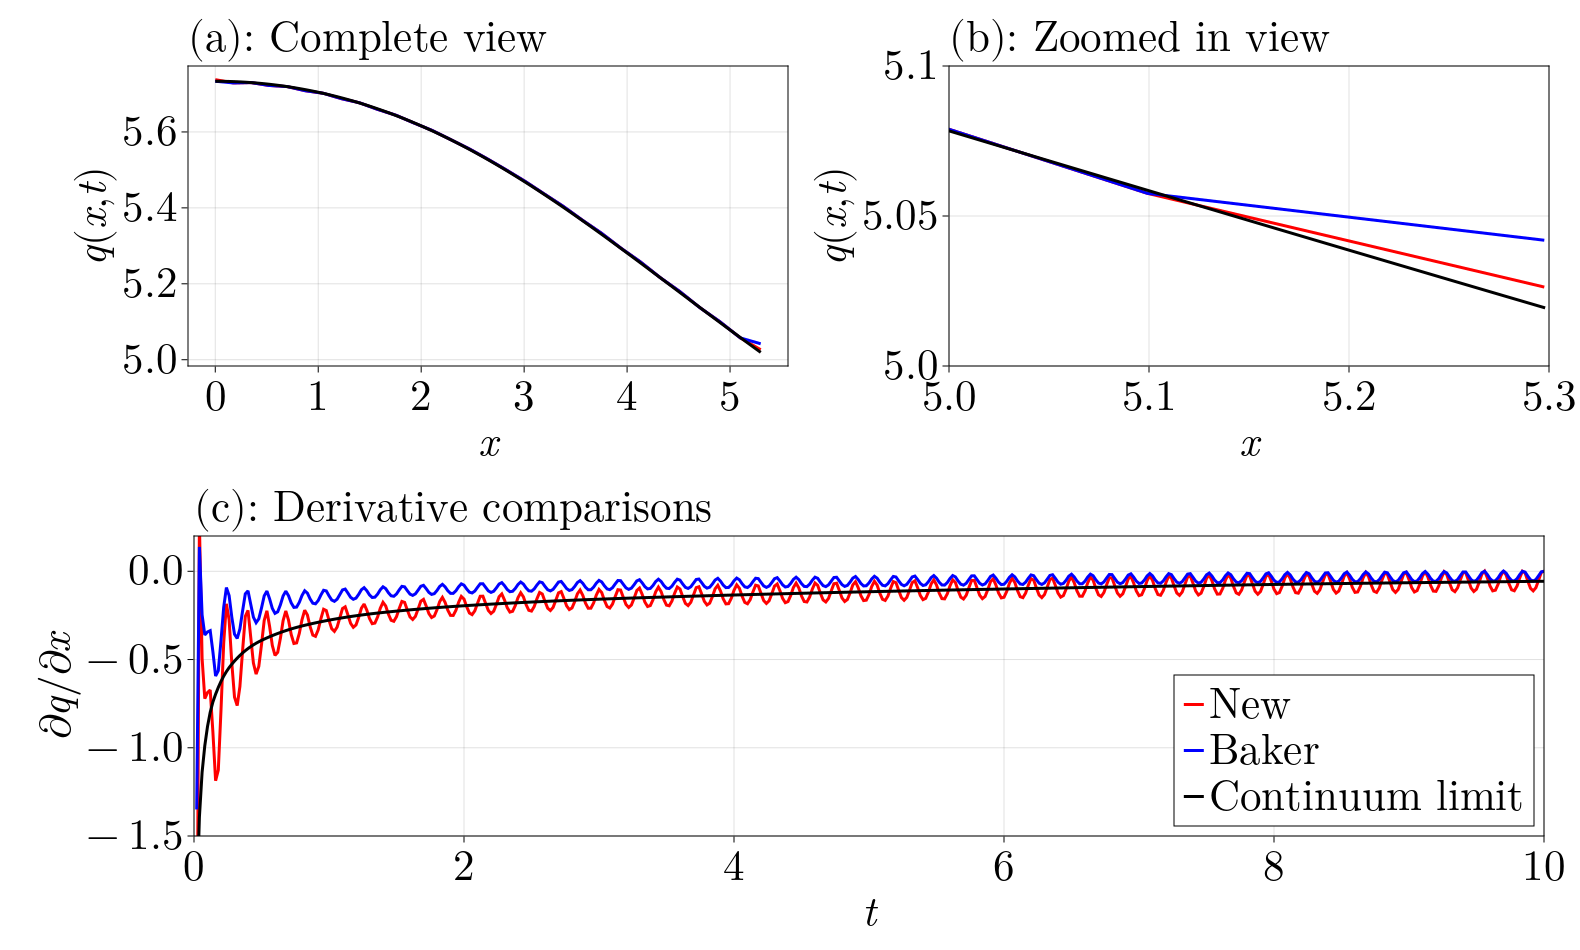

In [6]:
fig = Figure(fontsize=43, resolution=(1580, 950))
ax = Axis(fig[1, 1], xlabel=L"x", ylabel=L"q(x,t)",
    width=600, height=300,
    xticks=(0:6, [L"%$s" for s in 0:6]),
    yticks=(5:0.2:5.8, [L"%$s" for s in 5:0.2:5.8]),
    title=L"(a):$ $ Complete view",
    titlealign=:left)
lines!(ax, sol.u[t_idx], new_densities, linewidth=3, color=:red, label=L"$ $New")
lines!(ax, sol.u[t_idx], baker_densities, linewidth=3, color=:blue, label=L"$ $Baker")
lines!(ax, pde_x, pde_q, linewidth=3, color=:black, label=L"$ $Continuum limit")
ax = Axis(fig[1, 2], xlabel=L"x", ylabel=L"q(x,t)",
    width=600, height=300,
    title=L"(b):$ $ Zoomed in view",
    xticks=(5:0.1:5.3, [L"%$s" for s in 5:0.1:5.3]),
    yticks=(5:0.05:5.1, [L"%$s" for s in 5:0.05:5.1]),
    titlealign=:left)
lines!(ax, sol.u[t_idx], new_densities, linewidth=3, color=:red, label=L"$ $New")
lines!(ax, sol.u[t_idx], baker_densities, linewidth=3, color=:blue, label=L"$ $Baker")
lines!(ax, pde_x, pde_q, linewidth=3, color=:black, label=L"$ $Continuum limit")
xlims!(ax, 5, 5.3)
ylims!(ax, 5, 5.1)
ax = Axis(fig[2, 1:2],
    xlabel=L"t", ylabel=L"\partial q/\partial x",
    title=L"(c):$ $ Derivative comparisons",
    titlealign=:left,
    xticks=(0:2:10, [L"%$s" for s in 0:2:10]),
    yticks=(-1.5:0.5:0, [L"%$s" for s in -1.5:0.5:0]),
    width=1350,
    height=300)
lines!(ax, sol.t[2:end], new_dx[2:end], linewidth=3, color=:red, label=L"$ $New")
lines!(ax, sol.t[2:end], baker_dx[2:end], linewidth=3, color=:blue, label=L"$ $Baker")
lines!(ax, sol.t[2:end], continuum_dx[2:end], linewidth=3, color=:black, label=L"$ $Continuum limit")
xlims!(ax, 0, 10)
ylims!(ax, -1.5, 0.2)
axislegend(ax, position=:rb)
fig

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*